In [1]:
import numpy
import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sys
import matplotlib.dates as mdates
import datetime as dt

Using TensorFlow backend.


In [2]:
def saveGraph(data, file_name):
    plt.figure(dpi=360)
    plt.plot(data)
    plt.savefig('results/' + file_name)
def relative_error(xs, ys):
    error = 0
    zero = 0
    for i in range(len(xs)):
        if ys[i] != 0:
            error += abs(xs[i]-ys[i])*100 / ys[i]
        else:
            zero += 1
    error /= (len(xs) - zero)
    return error
def read_data(file_name):
    return pandas.read_csv('datas/' + file_name, usecols=[1], sep='|')
def saveGraphWithDate(dates, y_axis, file_name, format_date):
    plt.figure(dpi=360)
    x = [dt.datetime.strptime(d,format_date).date() for d in dates]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.plot(x,y_axis)
    plt.gcf().autofmt_xdate()
    plt.savefig('results/' + file_name)
def create_dataset(dataset, look_back=1):
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(dataset) - look_back):
        x = dataset[i:(i+look_back), :]
        if i <= int(len(dataset) * 0.67):
            trainX.append(x)
            trainY.append(dataset[i+look_back])
        else:
            testX.append(x)
            testY.append(dataset[i+look_back])
    return numpy.array(trainX), numpy.array(trainY), numpy.array(testX), numpy.array(testY)
    return numpy.array(trainX), numpy.array(trainY), numpy.array(testX), numpy.array(testY)

In [3]:
datafile = 'EOD-V.csv'
result_path = 'raw11'
epochs = 300

percents_correct = []
# look_backs = list(range(1, 10)) + list(range(12, 40, 2)) + list(range(45, 100, 5)) + list(range(120, 240, 20))
look_back = 7
# batch_sizes = list(range(1, 10)) + list(range(12, 20, 2)) + list(range(20, 50, 5))
# batch_sizes = list(range(20, 50, 5)) + list(range(50, 200, 10)) + list(range(200, 500, 20))
batch_sizes = [1]

In [4]:
for batch_size in batch_sizes:
    dataframe = pandas.read_csv('datas/' + datafile, sep='|')
    dataset = dataframe['close_price'].values.reshape(dataframe['close_price'].shape[0], 1)

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    # train_size = 566
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    trainX, trainY, testX, testY = create_dataset(dataset, look_back)
    trainX = trainX.reshape(trainX.shape[0], look_back, 1)
    testX = testX.reshape(testX.shape[0], look_back, 1)
    trainY = trainY.reshape(trainY.shape[0], 1)
    testY = testY.reshape(testY.shape[0], 1)

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

In [5]:
print('----- Predict Trend -----')
predict = []
dates_test = dataframe['date'].values[(len(dataset) - len(testY) - 1):(len(dataset)-1)]

for index, today_close_price in enumerate(testX):
    predict_tomorrow = model.predict(numpy.array([today_close_price]))[0]
    predict.append(predict_tomorrow)
    model.fit(numpy.array([today_close_price]), numpy.array([testY[index]]), epochs=epochs, batch_size=batch_size, verbose=0)



----- Predict Trend -----


In [6]:
predict = scaler.inverse_transform(predict)
testY = scaler.inverse_transform(testY)
testXT = scaler.inverse_transform(testX[:, -1])
with open('results/' + result_path + '/result.csv', 'w+') as file:
    file.write('close_price|predict\n')
    for i in range(len(testXT)):
        file.write(str(testXT[i][0]) + '|\n')
    for i in range(len(predict)):
        file.write(str(testY[i][0]) + '|' + str(predict[i][0]) + '\n')

today = scaler.inverse_transform(testX[:, look_back - 1])

_trend_reallity = [int(numpy.sign(b[0] - a[0])) for a, b in zip(today, testY)]
_trend_predict = [int(numpy.sign(b[0] - a[0])) for a, b in zip(today, predict)]
_correct = [1 if a == b else 0 for a, b in zip(_trend_reallity, _trend_predict)]
_percent_correct = 100*sum(_correct)/len(_correct)
percents_correct.append({'batch_size': batch_size, 'percent': _percent_correct})
print('Batch_size: ' + str(batch_size) + ' | percent: ' + str(_percent_correct))

with open('results/' + result_path + '/percents.csv', 'w+') as file:
    file.write('look_back|batch_size|percent\n')
    for i in percents_correct:
        file.write(str(look_back) + '|' + str(i['batch_size']) + '|' + str(i['percent']) + '\n')


Batch_size: 1 | percent: 46.7005076142132


In [20]:
data = pandas.read_csv('results/raw11/result.csv', sep='|')
for i in range(len(data)):
    if data['predict'][i] == data['predict'][i]:
        index_predict = i
        break
# two days
n = 2
_today = data['close_price'][index_predict-n:-1-n]
_trend_predict = [int(numpy.sign(b - a)) for a, b in zip(_today, data['predict'][index_predict:])]
_trend_reallity = [int(numpy.sign(b - a)) for a, b in zip(_today, data['close_price'][index_predict:])]
_correct = [1 if a == b else 0 for a, b in zip(_trend_reallity, _trend_predict)]
_percent_correct = 100*sum(_correct)/len(_correct)
print('Batch_size: ' + str(batch_size) + ' | percent: ' + str(_percent_correct))

Batch_size: 1 | percent: 69.89795918367346


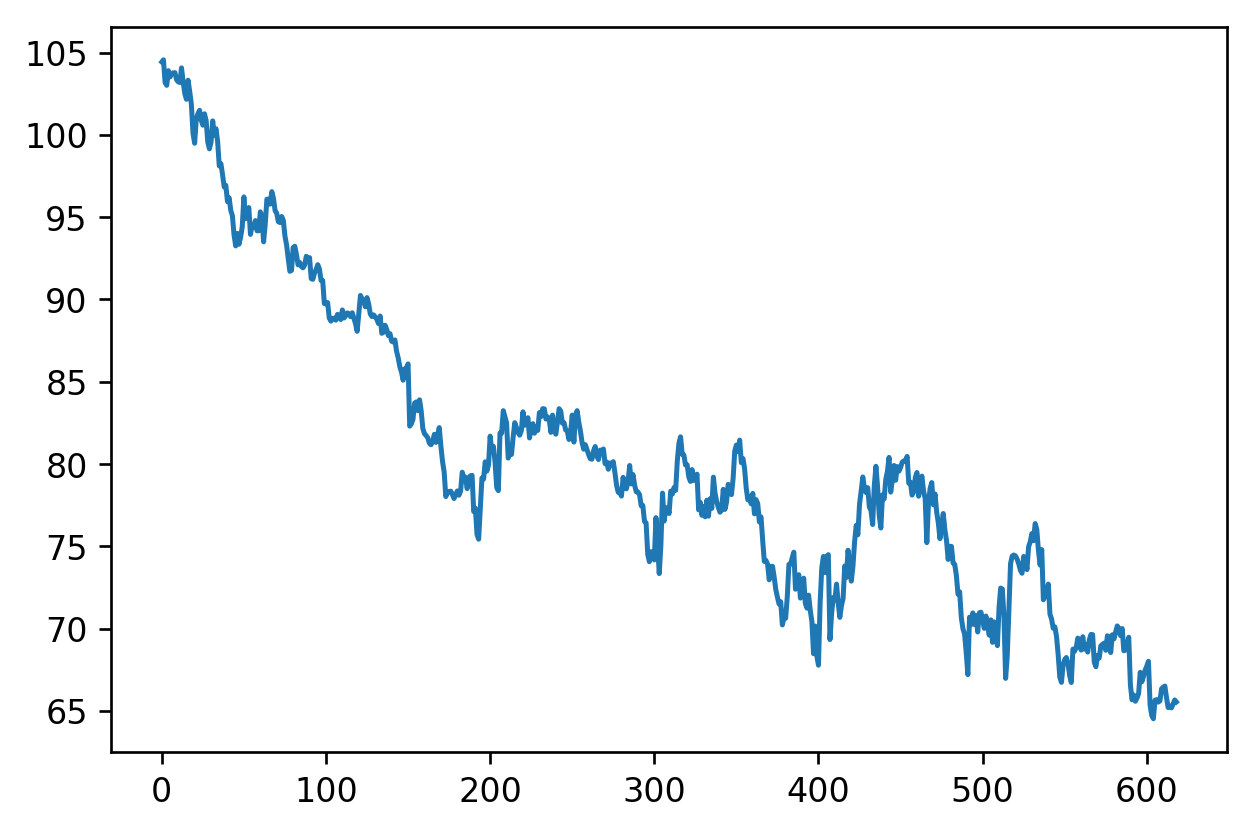

In [23]:
import matplotlib.pyplot as plt
plt.figure(dpi=240)
plt.plot(pandas.read_csv('datas/EOD-V.csv', sep='|')['close_price'])
plt.show()

In [ ]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sys
import matplotlib.dates as mdates
import datetime as dt

def saveGraph(data, file_name):
    plt.figure(dpi=360)
    plt.plot(data)
    plt.savefig('results/' + file_name)
def relative_error(xs, ys):
    error = 0
    zero = 0
    for i in range(len(xs)):
        if ys[i] != 0:
            error += abs(xs[i]-ys[i])*100 / ys[i]
        else:
            zero += 1
    error /= (len(xs) - zero)
    return error
def read_data(file_name):
    return pandas.read_csv('datas/' + file_name, usecols=[1], sep='|')
def saveGraphWithDate(dates, y_axis, file_name, format_date):
    plt.figure(dpi=360)
    x = [dt.datetime.strptime(d,format_date).date() for d in dates]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.plot(x,y_axis)
    plt.gcf().autofmt_xdate()
    plt.savefig('results/' + file_name)
def create_dataset(dataset, look_back=1):
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(dataset) - look_back):
        x = dataset[i:(i+look_back), :]
        if i <= int(len(dataset) * 0.67):
            trainX.append(x)
            trainY.append(dataset[i+look_back])
        else:
            testX.append(x)
            testY.append(dataset[i+look_back])
    return numpy.array(trainX), numpy.array(trainY), numpy.array(testX), numpy.array(testY)



datafile = 'data_stock_market.csv'
result_path = 'raw'
format_date='%d/%m/%Y'
epochs = 100

percents_correct = []
look_back = 7
batch_sizes = [1, 2, 3, 4, 5, 6, 8, 10]

for batch_size in batch_sizes:
    dataframe = pandas.read_csv('datas/' + datafile, sep='|')
    dataset = dataframe['close_price'].values.reshape(dataframe['close_price'].shape[0], 1)

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    trainX, trainY, testX, testY = create_dataset(dataset, look_back)
    trainX = trainX.reshape(trainX.shape[0], look_back, 1)
    testX = testX.reshape(testX.shape[0], look_back, 1)
    trainY = trainY.reshape(trainY.shape[0], 1)
    testY = testY.reshape(testY.shape[0], 1)

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2)


    print('----- Predict Trend -----')
    predict = []
    dates_test = dataframe['date'].values[(len(dataset) - len(testY) - 1):(len(dataset)-1)]

    for index, today_close_price in enumerate(testX):
        predict_tomorrow = model.predict(numpy.array([today_close_price]))[0]
        predict.append(predict_tomorrow)
        model.fit(numpy.array([today_close_price]), numpy.array([testY[index]]), epochs=epochs, batch_size=batch_size, verbose=0)

    predict = scaler.inverse_transform(predict)
    testY = scaler.inverse_transform(testY)

    with open('results/' + result_path + '/result.csv', 'w+') as file:
        file.write('close_price|predict\n')
        for i in range(len(predict)):
            file.write(str(testY[i][0]) + '|' + str(predict[i][0]) + '\n')

    today = scaler.inverse_transform(testX[:, look_back - 1])

    _trend_reallity = [int(numpy.sign(b[0] - a[0])) for a, b in zip(today, testY)]
    _trend_predict = [int(numpy.sign(b[0] - a[0])) for a, b in zip(today, predict)]
    _correct = [1 if a == b else 0 for a, b in zip(_trend_reallity, _trend_predict)]
    _percent_correct = 100*sum(_correct)/len(_correct)
    percents_correct.append({'batch_size': batch_size, 'percent': _percent_correct})

    with open('results/' + result_path + '/percents.csv', 'w+') as file:
        file.write('look_back|batch_size|percent\n')
        for i in percents_correct:
            file.write(str(look_back) + '|' + str(i['batch_size']) + '|' + str(i['percent']) + '\n')


In [ ]:
percents